In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression

from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import lime as lm

ModuleNotFoundError: No module named 'lime'

In this section we will load in dataset and perform necessary manipulations:
+ Split out date into year and quarter
+ Split out and one hot encode genres
+ One hot encode MPAA rating;
+ Match director to average gross, fill in missing values with average


In [110]:
moviesdf = pd.read_csv("movie_data_3.csv")

In [111]:
directorsdf = pd.read_csv("dirstats.csv")

In [112]:
dir_dict  = pd.Series(directorsdf.AveDirBox.values,index=directorsdf.Name).to_dict()

In [113]:
moviesdf["DirAveBox"] = moviesdf["director"].map(dir_dict)

In [114]:
moviesdf.loc[moviesdf.DirAveBox.isna(),'DirAveBox'] = moviesdf.DirAveBox.mean()

In [115]:
moviesdf['date'] = pd.to_datetime(moviesdf.date)

In [116]:
moviesdf['year'] = moviesdf['date'].dt.year

In [117]:
moviesdf['quarter'] = moviesdf['date'].dt.quarter.astype(str)

In [10]:
#moviesdf['preqandgross'] = moviesdf['prequel']*moviesdf['prequel_gross']
#moviesdf['yearpreqgross'] = moviesdf['year']*moviesdf['prequel_gross']
#moviesdf.groupby(moviesdf.DirAveBox.isna()).agg("mean")

Encoding genres, mpaa, distributors and creating dummies

In [118]:
diststats = pd.read_csv('diststats.csv')

In [119]:
dist_dict  = pd.Series(diststats.distpermov.values,index=diststats.Distributor).to_dict()

In [120]:
moviesdf.distributor = moviesdf.distributor.str.strip()

In [121]:
moviesdf["distpermov"] = moviesdf["distributor"].map(dist_dict)

In [1]:
genrelist = moviesdf.genres.str.split() 
moviesdf['genrelist'] = genrelist

NameError: name 'moviesdf' is not defined

In [123]:
moviesdf.loc[moviesdf.distpermov.isna(),'distpermov'] = moviesdf.distpermov.mean()

In [124]:
genres=[]
for glist in genrelist:
    genres.extend(glist)
    
genreset = set(genres)


In [125]:
for genre in genreset:
    moviesdf[genre] = 0
    for i,row in moviesdf.iterrows():
        if genre in row.genrelist:
            moviesdf.loc[i,genre] = 1
        



In [247]:
#moviesdf.mpaa.replace({"G":"PG"}, inplace = True)
#moviesdf.mpaa.value_counts()

In [126]:
#To code distributor as categorical
bigstudios = moviesdf.distributor.value_counts().index.to_list()[:9]
moviesdf.loc[~moviesdf.distributor.isin(bigstudios),'distributor'] = "Otherstudios"
moviesdf.distributor.value_counts()

Warner Bros.               151
Universal Pictures         146
Walt Disney Studios        137
Twentieth Century Fox      126
Sony Pictures Releasing    109
Otherstudios               101
Paramount Pictures          92
Lionsgate                   49
Screen Gems                 23
DreamWorks                  22
Name: distributor, dtype: int64

In [127]:
moviesdf = pd.get_dummies(moviesdf,columns = ['mpaa','distributor','quarter'],drop_first = True)

In [128]:
moviesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 59 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   rank                                 956 non-null    object        
 1   title                                956 non-null    object        
 2   opening_gross                        956 non-null    int64         
 3   prequel_gross                        956 non-null    int64         
 4   theaters                             956 non-null    int64         
 5   budget                               956 non-null    int64         
 6   act_star                             956 non-null    int64         
 7   starmeter_1                          956 non-null    int64         
 8   starmeter_2                          956 non-null    int64         
 9   prequel                              956 non-null    int64         
 10  genres        

Basic dataframe built! Changes going forward should be done below the line and saved in new dataframes

In [259]:

#All variables:
moviesfin = moviesdf.loc[:,moviesdf.dtypes != object].drop(columns =['act_star','total_gross','percent_of_total','average','Music','date'])
#No categorical variables:
#moviesfin = moviesdf.loc[:,['opening_gross','prequel_gross','theaters','budget','starmeter_1','starmeter_2','DirAveBox','year','distpermov']]
#Experimenting with which categoricals to drop:
#moviesfin = moviesdf.loc[:,moviesdf.dtypes != object].drop(columns =['act_star','total_gross','percent_of_total','average','Music','date','quarter_2','quarter_3','quarter_4','mpaa_PG','mpaa_PG-13','mpaa_R'])


In [260]:
moviesfin['theatersq'] = moviesfin.theaters**2
#moviesfin['logopening'] = np.log(moviesfin.opening_gross)
#moviesfin['budgetsq'] = moviesfin.budget**2
#moviesfin['bigpreq'] = moviesfin.prequel*moviesfin.prequel_gross
#moviesfin['superstar'] = moviesfin.starmeter_1*moviesfin.starmeter_2

In [239]:
moviesfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   opening_gross                        956 non-null    int64  
 1   prequel_gross                        956 non-null    int64  
 2   theaters                             956 non-null    int64  
 3   budget                               956 non-null    int64  
 4   starmeter_1                          956 non-null    int64  
 5   starmeter_2                          956 non-null    int64  
 6   prequel                              956 non-null    int64  
 7   DirAveBox                            956 non-null    float64
 8   year                                 956 non-null    int64  
 9   distpermov                           956 non-null    float64
 10  Fantasy                              956 non-null    int64  
 11  Musical                         

In [262]:
y = moviesfin.opening_gross
X = moviesfin.drop('opening_gross',axis=1)
#For log transformed model                    
#y = moviesfin.logopening
#X = moviesfin.drop(['opening_gross','logopening'],axis=1)

In [68]:
moviesfin.iloc[:,:10]

,opening_gross,prequel_gross,theaters,budget,starmeter_1,starmeter_2,prequel,DirAveBox
0,24105943,0,2648,35000000,2238,734,0,5.261600e+07
1,27487144,0,3003,40000000,1058,281,0,4.843261e+07
2,70885301,0,3103,65000000,144,792,0,1.319613e+08
3,20617667,0,2678,25000000,247,2558,0,8.824104e+07
4,65237614,0,3404,200000000,247,593,0,8.993750e+07
...,...,...,...,...,...,...,...,...
951,21525560,0,3131,54000000,1042,1120,0,3.801370e+08
952,24733155,0,3036,23600000,1479,703,0,8.905493e+07
953,26803104,24733155,3468,42000000,703,1479,1,8.905493e+07
954,20065617,0,3482,80000000,1724,794,0,6.389323e+07


Data manipulation done! Next follows the basic analysis action on our final moviesfin dataframe!

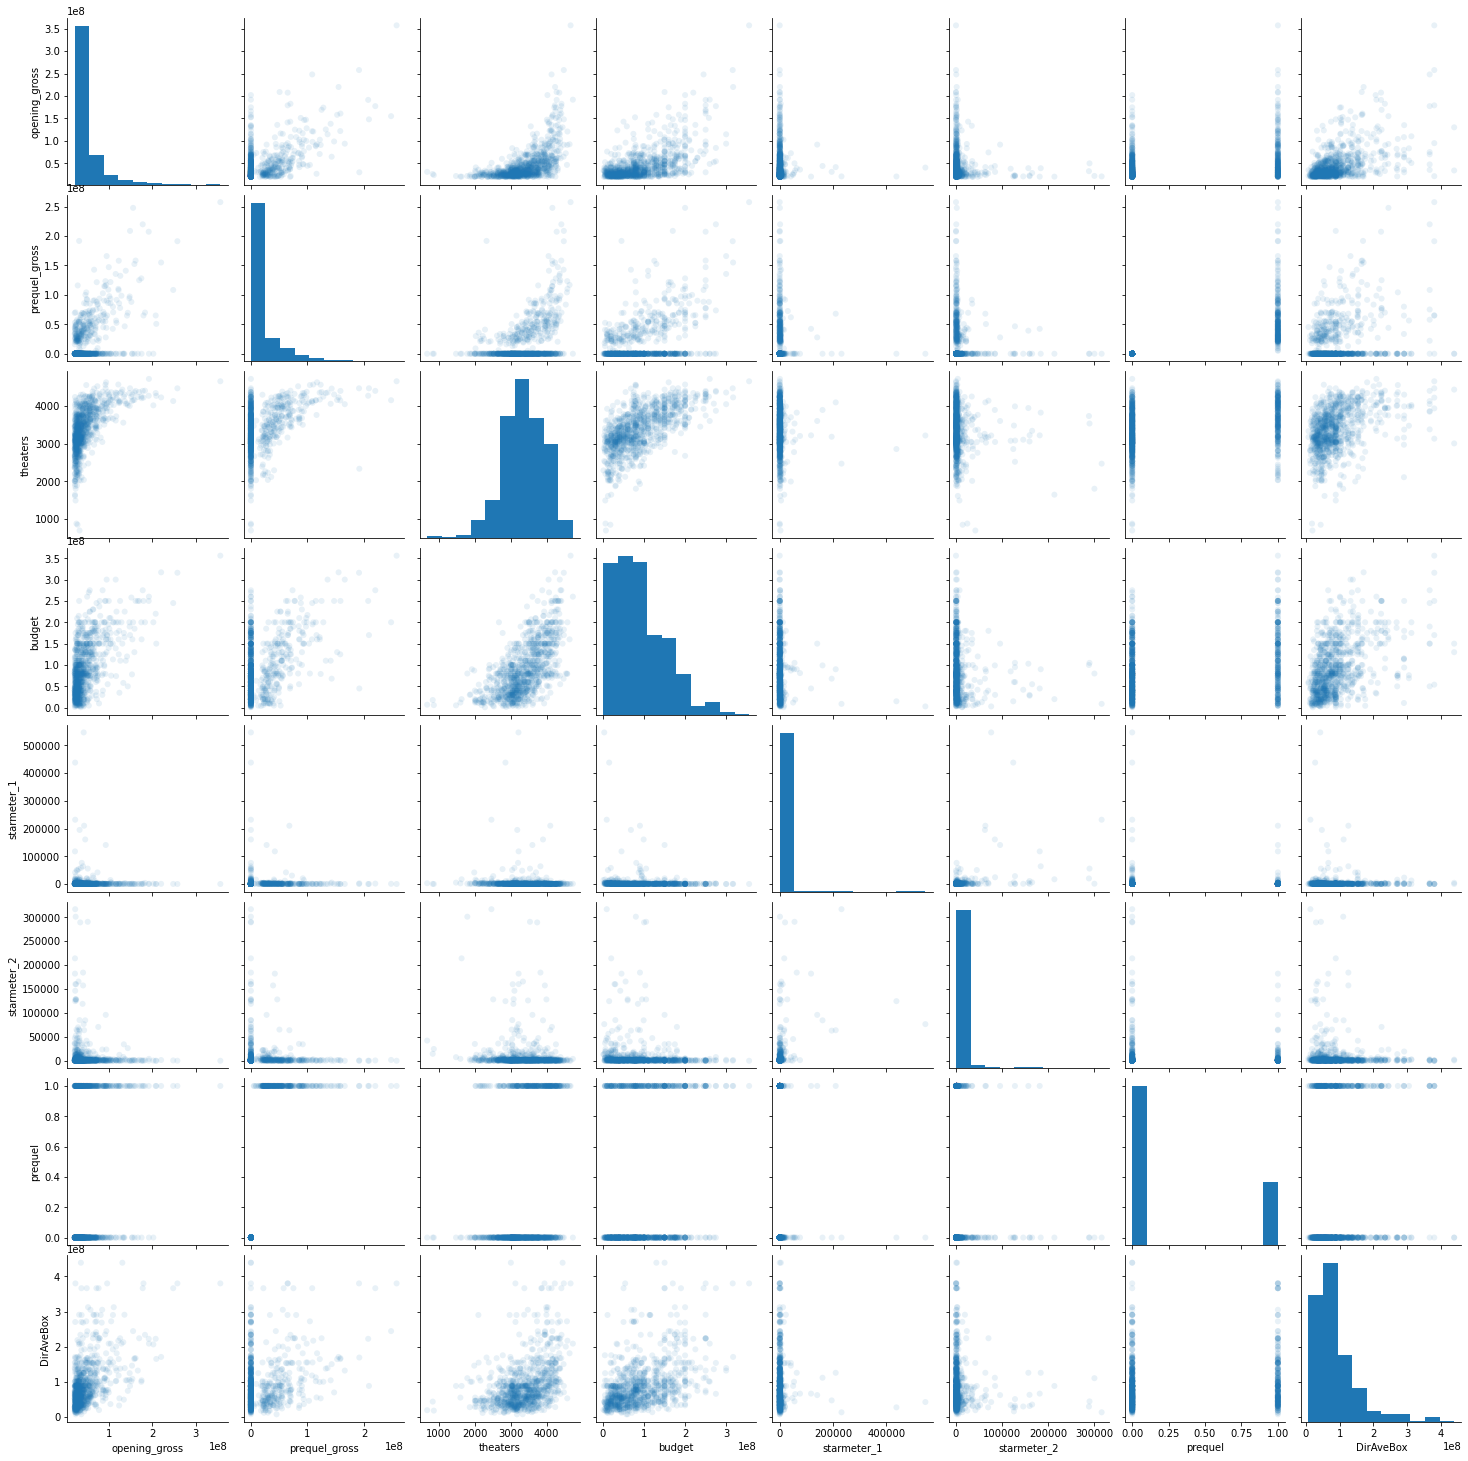

In [71]:
sns.pairplot(moviesfin.iloc[:,:8], plot_kws=dict(alpha=.1, edgecolor='none'))

In [264]:
moviesfin.iloc[:,:10].corr()

,opening_gross,prequel_gross,theaters,budget,starmeter_1,starmeter_2,prequel,DirAveBox,year,distpermov
opening_gross,1.000000,0.582843,0.568775,0.594811,-0.032785,-0.082590,0.323732,0.520300,0.220561,0.210931
prequel_gross,0.582843,1.000000,0.422253,0.449627,-0.021552,-0.056942,0.770942,0.299546,0.226516,0.066192
theaters,0.568775,0.422253,1.000000,0.637480,-0.039332,-0.101104,0.310906,0.401155,0.488012,0.199178
budget,0.594811,0.449627,0.637480,1.000000,-0.077899,-0.097390,0.253351,0.454966,0.164940,0.290459
starmeter_1,-0.032785,-0.021552,-0.039332,-0.077899,1.000000,0.380084,-0.018012,-0.040986,-0.012929,-0.061429
starmeter_2,-0.082590,-0.056942,-0.101104,-0.097390,0.380084,1.000000,-0.045357,-0.084113,-0.008775,-0.095999
prequel,0.323732,0.770942,0.310906,0.253351,-0.018012,-0.045357,1.000000,0.138649,0.186725,-0.063108
DirAveBox,0.520300,0.299546,0.401155,0.454966,-0.040986,-0.084113,0.138649,1.000000,0.122809,0.278169
year,0.220561,0.226516,0.488012,0.164940,-0.012929,-0.008775,0.186725,0.122809,1.000000,-0.013288
distpermov,0.210931,0.066192,0.199178,0.290459,-0.061429,-0.095999,-0.063108,0.278169,-0.013288,1.000000


Basic split and validate

In [196]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)
    
    # fit linear regression to training data
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # score fit model on validation data
    train_score = lr.score(X_train,y_train)
    val_score = lr.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Training R^2 score was:', train_score)

    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr.coef_):
        print(feature, ':', f'{coef:.5f}')
    
    return  X_val,y_val,X_test,y_test,X_train,y_train,lr
    

In [265]:
X_val,y_val,X_test,y_test,X_train,y_train,lr = split_and_validate(X, y)


Validation R^2 score was: 0.5863719276797843
Training R^2 score was: 0.6436505542072533
Feature coefficient results: 

prequel_gross : 0.23392
theaters : -66595.35640
budget : 0.03999
starmeter_1 : 10.34583
starmeter_2 : 0.76995
prequel : -4579656.09087
DirAveBox : 0.11320
year : -808335.84886
distpermov : -0.16569
Fantasy : -3774945.59282
Musical : 1449510.71959
Drama : 4615438.66352
Mystery : 522779.73794
Adventure : -2391272.12040
Horror : 1467538.71755
Romance : -1819614.86216
Thriller : -4465848.24624
Biography : -3150211.83235
History : -6729892.14684
Family : -6650115.11517
Action : 1485912.22789
Animation : -483880.49030
War : -6533020.41714
Crime : 244567.62411
Documentary : 262744.59037
Western : -13275795.47078
Sci-Fi : 1261418.19341
Sport : -3135899.19330
Comedy : -955192.71018
mpaa_PG : 4603328.68525
mpaa_PG-13 : 10849903.84409
mpaa_R : 13832593.67730
distributor_Lionsgate : 5228730.44008
distributor_Otherstudios : 2665002.89795
distributor_Paramount Pictures : 3987843.99

In [266]:
#Performance on test:
test_score = lr.score(X_test,y_test)
print('test score : {:.3f}'.format(test_score))
y_hat=lr.predict(X_test)
y_pred = lr.predict(X_train)
test_rmse = np.sqrt(mean_squared_error(y_test,y_hat))
train_rmse = np.sqrt(mean_squared_error(y_train,y_pred))
print('test RMSE : {:.2f}'.format(test_rmse))
print('train RMSE : {:.2f}'.format(train_rmse))

test score : 0.674
test RMSE : 22370651.32
train RMSE : 18946962.79


Residual plots

Text(0.5, 0, 'Predicted Ys')

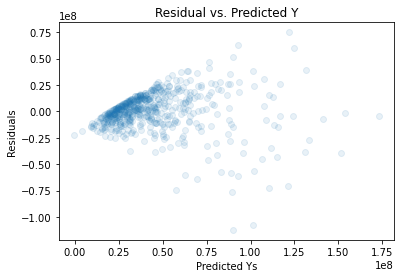

In [267]:
# Calculate residuals
#    Recall: residual = y_pred - y
residuals = y_pred - y_train

# Plot predictions (x-axis) vs residuals (y-axis) using plt.scatter()
#    In scatter set alpha=0.2 to make the markers somewhat transparent.
#    Set axis/label names appropriately ('y_pred' and 'residuals')
# The residuals should appear fairly normal around 0 across the range of y_pred
plt.scatter(y_pred,residuals,alpha=.1)
plt.title('Residual vs. Predicted Y')
plt.ylabel('Residuals')
plt.xlabel('Predicted Ys')

Text(0.5, 1.0, 'Distribution plot of residuals')

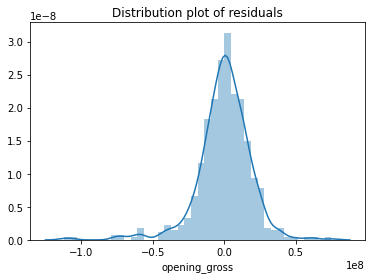

In [268]:
sns.distplot(residuals)
plt.title('Distribution plot of residuals')

Ridge regression and polynomials

In [269]:
#set up the 3 models we're choosing from:


#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge()
lm_l2 = Lasso()

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [210]:
x_train_poly = poly.fit_transform(X_train)
m.fit(x_train_poly,y_train)
m.score(x_train_poly,y_train)
#print(f'Poly training score: {lm_poly.score(X_test_poly, y_test):.3f} ,Poly val score:')

0.3005880813122167

In [270]:
#validate

print(f'Linear Regression val R^2: {lr.score(X_val, y_val):.3f}')
print(f'Linear Regression test R^2: {lr.score(X_test, y_test):.3f}\n')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}\n')

lm_l2.fit(X_train_scaled, y_train)
print(f'Lasso Regression val R^2: {lm_l2.score(X_val_scaled, y_val):.3f}')
print(f'Lasso Regression test R^2: {lm_l2.score(X_test_scaled, y_test):.3f}\n')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')


Linear Regression val R^2: 0.586
Linear Regression test R^2: 0.674

Ridge Regression val R^2: 0.587
Ridge Regression test R^2: 0.675

Lasso Regression val R^2: 0.586
Lasso Regression test R^2: 0.674

Degree 2 polynomial regression val R^2: -27.092
Degree 2 polynomial regression test R^2: -5.824


C:\Users\tskth\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2972528785699072e+16, tolerance: 57724175534188.63
  positive)


Cross-Validation

In [277]:
lm = LinearRegression()

cv_scorelm = cross_val_score(lm, X, y, # estimator, features, target
                cv=3, # number of folds 
                scoring='r2') # scoring metric
print(f'Mean linear regression CV score of : {cv_scorelm.mean():.3f} and standard deviation of {cv_scorelm.std():.3f}')


Mean linear regression CV score of : 0.575 and standard deviation of 0.067


In [278]:
reg2 = Ridge()

cv_scoreridge = cross_val_score(reg2, X, y, # estimator, features, target
                cv=3, # number of folds 
                scoring='r2') # scoring metric

print(f'Mean ridge regression CV score of : {cv_scoreridge.mean():.3f} and standard deviation of {cv_scoreridge.std():.3f}')


Mean ridge regression CV score of : 0.580 and standard deviation of 0.061


C:\Users\tskth\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.84726e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\tskth\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.00448e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\tskth\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.09365e-19): result may not be accurate.
  overwrite_a=True).T


In [283]:
l2 = Lasso()

cv_lasso = cross_val_score(l2, X, y, # estimator, features, target
                cv=3, # number of folds 
                scoring='r2') # scoring metric

print(f'Mean ridge regression CV score of : {cv_lasso.mean():.3f} and standard deviation of {cv_lasso.std():.3f}')

Mean ridge regression CV score of : 0.575 and standard deviation of 0.067


C:\Users\tskth\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1675613858107629e+17, tolerance: 64757111756364.766
  positive)
C:\Users\tskth\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2808255717138054e+17, tolerance: 82572746297527.81
  positive)
C:\Users\tskth\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1780686435631995e+17, tolerance: 70407222519396.14
  positive)


In [279]:
pipe = Pipeline([('scaler',StandardScaler()),('ridge',Ridge(alpha=100))])

In [280]:
cv_scoreridgescale = cross_val_score(pipe, X, y, # estimator, features, target
                cv=3, # number of folds 
                scoring='r2') # scoring metric

print(f'Mean scaled ridge regression CV score of : {cv_scoreridgescale.mean():.3f} and standard deviation of {cv_scoreridgescale.std():.3f}')


Mean scaled ridge regression CV score of : 0.571 and standard deviation of 0.029


In [281]:
pipe2 = Pipeline([('scaler',StandardScaler()),('lasso',Lasso(alpha=100))])

In [282]:
cv_scorelassoscale = cross_val_score(pipe2, X, y, # estimator, features, target
                cv=3, # number of folds 
                scoring='r2') # scoring metric

print(f'Mean scaled ridge regression CV score of : {cv_scorelassoscale.mean():.3f} and standard deviation of {cv_scorelassoscale.std():.3f}')


Mean scaled ridge regression CV score of : 0.575 and standard deviation of 0.067


C:\Users\tskth\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.529942695730381e+16, tolerance: 64757111756364.766
  positive)


More detailed testing of polynomial features

In [ ]:
x_train_poly = poly.fit_transform(X_train)
m.fit(x_train_poly,y_train)
m.score(x_train_poly,y_train)
#print(f'Poly training score: {lm_poly.score(X_test_poly, y_test):.3f} ,Poly val score:')

In [103]:
p.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23',
 'x24',
 'x25',
 'x26',
 'x27',
 'x28',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x0 x11',
 'x0 x12',
 'x0 x13',
 'x0 x14',
 'x0 x15',
 'x0 x16',
 'x0 x17',
 'x0 x18',
 'x0 x19',
 'x0 x20',
 'x0 x21',
 'x0 x22',
 'x0 x23',
 'x0 x24',
 'x0 x25',
 'x0 x26',
 'x0 x27',
 'x0 x28',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x1 x8',
 'x1 x9',
 'x1 x10',
 'x1 x11',
 'x1 x12',
 'x1 x13',
 'x1 x14',
 'x1 x15',
 'x1 x16',
 'x1 x17',
 'x1 x18',
 'x1 x19',
 'x1 x20',
 'x1 x21',
 'x1 x22',
 'x1 x23',
 'x1 x24',
 'x1 x25',
 'x1 x26',
 'x1 x27',
 'x1 x28',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x2 x8',
 'x2 x9',
 'x2 x10',
 'x2 x11',
 'x2 x12',
 'x2 x13',
 'x2 x14',
 'x2 x15',
 'x2 x16',
 'x2 x17',

In [52]:
m = LassoCV()
p = PolynomialFeatures(degree=2)
m.fit(p.fit_transform(X_train),y_train)
m.score(p.transform(X_train),y_train)

0.5066265071341856

MVP - Prequel and Prequel Gross appear to be strong predictors on a standalone basis

In [224]:
movieswithprequels = moviesdf[moviesdf.prequel==1]

Text(0, 0.5, 'Opening weekend gross (hundred $M)')

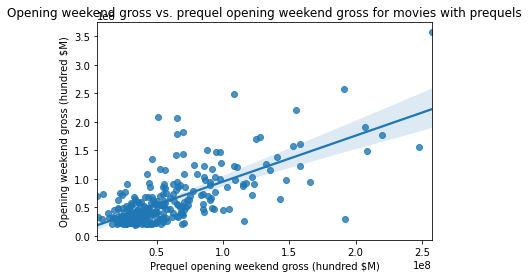

In [225]:
plt.title("Opening weekend gross vs. prequel opening weekend gross for movies with prequels")
sns.regplot(movieswithprequels.prequel_gross, movieswithprequels.opening_gross, )
plt.xlabel("Prequel opening weekend gross (hundred $M)")
plt.ylabel("Opening weekend gross (hundred $M)")

In [226]:
yp = movieswithprequels['opening_gross']
Xp2= movieswithprequels[['prequel_gross','budget']]
#Xp = movieswithprequels[['prequel_gross','year','budget']]


Validation R^2 score was: 0.39101564475528117
Training R^2 score was: 0.5786287110656303
Feature coefficient results: 

prequel_gross : 0.68
budget : 0.20


LinearRegression()

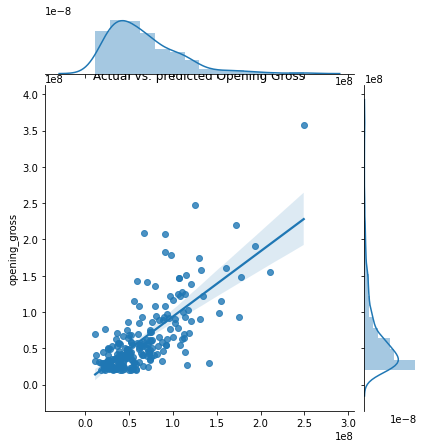

In [227]:
split_and_validate(Xp2,yp)